# Comet equation with MLDA
$
	\begin{cases}
		- \mu \Delta u + 10(\text{cos}\theta, \text{sin}\theta) \cdot \nabla u = f \quad\quad & \underline{x} \in \Omega = \left[0,1\right]^2\\
		u = 0 & \underline{x} \in \partial \Omega
	\end{cases}
$

## Import modules

In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [2]:
# Import modules

import os as os
import warnings

import sys
import time
import arviz             as az
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy             as np
import pandas            as pd

import pymc3             as pm
import theano
import theano.tensor     as tt

from fenics import *

# Further technicalities

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")


# Checking versions

print(f"Theano version: {theano.__version__}")
print(f"PyMC3  version: {pm.__version__}")

Theano version: 1.1.2
PyMC3  version: 3.11.4


## Settings

In [3]:
# System

stochastic  = False         # random seeds for the experiments

RANDOM_SEED = 123446        # sampling seed
NUMPY_SEED  = 123           # Numpy    seed


# True model

mu_true    = 2              # diffusion parameter
theta_true = np.pi          # advection angle parameter

n_params   = 2              # number of unknown quantities

x_0   = np.array([0.5,0.5]) # center of the bump source-force

forcing = '10*exp(-50*pow( pow(x[0]-x_00, 2) + pow(x[1]-x_01, 2), 0.5))' # forcing term in the PDE

noise_scale = 0.00001       # noise scale in the output data


# PDE solver

poly_degree = 2                      # polynomial degree for the FEniCS solver

n_data_hv_true   = 256               # number of segments on both vertical and horizontal axis, for the true model
n_data_hv_levels = np.array([16,32]) # number of segments on both vertical and horizontal axis, for each level of approximation


# Priors for unknown parameters

lower_mu    = 0.1       # lower bound for mu    (supposing mu ~ Uniform)
upper_mu    = 5         # upper bound for mu
lower_theta = 0         # lower bound for theta (supposing theta ~ Uniform)
upper_theta = 2*np.pi   # upper bound for theta

# starting point 
use_MAP_as_start = False  # set true to use MAP as starting point, else uses [mu_0, theta_0] (sembra dare problemi MAP)
mu_0        = 3.5         # initial guess for mu unknown parameter
theta_0     = 2           # initial guess for theta unknown parameter
 

# Likelihood

sigma = np.array([0.0005,0.0004]) # value that determines the variance in the likelihood (first: coarse; last: fine)

plot_likelihood = True  # plot likelihood at each level 
n_ref_lik   = 30        # precision of the grid for the plot
contour_lik = 10        # number of contour lines in each plot


# MCMC: Metropolis and MLDA

perform_M    = True    # perform the Metropolis sampling

ndraws_M     = 2700    # number of draws from the distribution for M
nburn_M      =  300    # number of burn-in samples for M
nchains_M    = 1       # number of chains for M


perform_MLDA_without_variance_reduction = True   # perform the MLDA sampling without variance reduction
perform_MLDA_with_variance_reduction    = True   # perform the MLDA sampling with variance reduction

ndraws_MLDA  = 1300     # number of draws from the distribution for MLDA
nburn_MLDA   =  300     # number of burn-in samples for MLDA
nchains_MLDA = 1        # number of chains for MLDA
nsub_MLDA    = 2        # subsampling rate for MLDA


tune           = True
tune_interval  = 100   # set high to prevent tuning
discard_tuning = True



In [4]:
# Grid on which we compare exact solution and numerical solution

# by hand data grid
custom_data_grid = np.array([[0.85, 0.5 ],
                             [0.5 , 0.85],
                             [0.5 , 0.15],
                             [0.15, 0.5 ]])
# uniform data grid
n_points = 5
unif_data_grid = np.dstack(np.meshgrid(np.linspace(0,1,n_points+2)[1:-1], np.linspace(0,1,n_points+2)[1:-1])).reshape(-1, 2)

# select which grid to use
data_grid = custom_data_grid

In [5]:
n_qoi = 2 # number of Quantities of Interest
qoi_names = []

## Definition of the Quantities of Interest

def QoIs(params):
  qoi_names.append("mu")
  mu = params[0]
  
  qoi_names.append("theta")
  theta = params[1]
  
  return mu, theta

In [6]:
# Set seed (in case it's needed)

if(not stochastic):
    np.random.seed(NUMPY_SEED)

## Define the Comet-Equation model and generate data

In [7]:
class CometEquation:
    """
    CometEquation is a class that implements the solution of the so called Comet Equation
    in the domain [0,1]x[0,1] for a given value of the parameters \mu and \theta
    """

    def __init__(self, mu_true, theta_true, x_0, forcing, poly_degree, n_data_hv_true, data_grid, noise_scale):

        # Set the quantities related to the true PDE

        self.mu      = mu_true
        self.theta   = theta_true

        self.x_0     = x_0

        self.forcing = forcing


        # Set the number of segments of the 2D mesh for both axes, and polynomial degree

        self.n_data_hv   = n_data_hv_true
        self.poly_degree = poly_degree


        # Create mesh and define function space

        mesh = UnitSquareMesh(n_data_hv_true, n_data_hv_true)
        V = FunctionSpace(mesh, 'P', poly_degree)


        # Define boundary conditions

        u_D = Constant(0)     # Homogeneous (null) boundary conditions

        def boundary(x, on_boundary):
            return on_boundary

        bc = DirichletBC(V, u_D, boundary)


        # Define variational problem: find u in V st a(u,v) = L(v) for all v in V

        u = TrialFunction(V)
        v = TestFunction (V)

        f = Expression(forcing, degree = poly_degree, x_00 = x_0[0], x_01 = x_0[1])

        b = Constant((np.cos(theta_true), np.sin(theta_true)))
        a = mu_true * dot(grad(u), grad(v)) * dx + 10 * dot(b,grad(u)) * v * dx

        L = f*v*dx


        # Compute solution

        u = Function(V)
        solve(a == L, u, bc)

        self.solution = u


        # Set the data grid and the solution on such grid
        
        self.grid_points   = data_grid                                                # matrix whose rows are the points of the data grid
        self.grid_solution = np.array([self.solution(point) for point in data_grid])  # vector with the solution on the data grid
        
        
        # Set all points of the grid and the correspondig solution
        
        self.all_grid_points = np.dstack(np.meshgrid(np.linspace(0,1,n_data_hv_true), np.linspace(0,1,n_data_hv_true))).reshape(-1, 2)
        self.all_grid_solution = np.array([self.solution(point) for point in self.all_grid_points])
        
        
        # Add noise to the data

        noise           = np.random.normal(0,noise_scale, len(self.grid_solution) )   # gaussian noise on the real solution of the PDE
        self.grid_data  = self.grid_solution + noise                                  # visible data
        
        self.all_grid_data = self.all_grid_solution + np.random.normal(0,noise_scale, len(self.all_grid_solution) )
    
    def plot_model_data(self):

        # plot(self.solution)
        fig1, ax1 = plt.subplots(1,1, figsize=(8, 6), dpi=80)

        im = ax1.scatter(x = self.all_grid_points[:,0], 
                         y = self.all_grid_points[:,1],
                         c = self.all_grid_data)
        ax1.scatter(self.grid_points[:,0], self.grid_points[:,1], marker='x', s = 200, c='red')
        fig1.colorbar(im)
        ax1.title.set_text('True PDE solution and selected data (with noise)')
        fig1.show()
        fig1.savefig("sol_avail_data.png")
        
    def plot_model(self):
        plot(self.solution)

Solving linear variational problem.


/var/folders/zh/jv1b2t351dx2rqz29grjnb_r0000gn/T/ipykernel_63468/1092770925.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


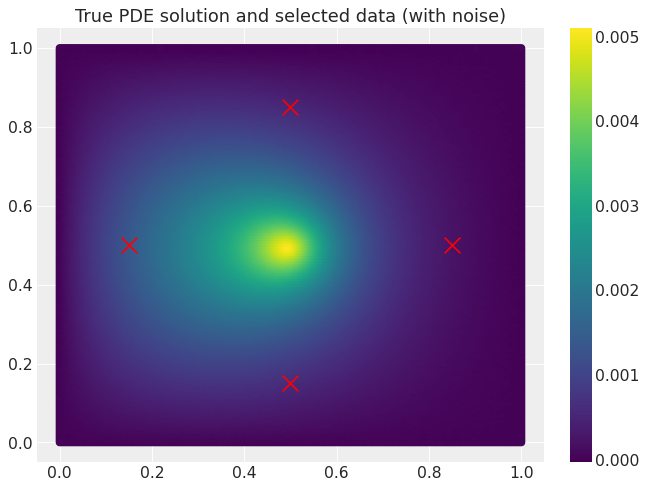

In [8]:
# Initialise a model

model_true = CometEquation(mu_true, theta_true, x_0, forcing, poly_degree, n_data_hv_true, data_grid, noise_scale)

# Plot the true PDE solution and the signal (data)

model_true.plot_model_data()


In [9]:
print(model_true.grid_data)
print(model_true.grid_solution)

[0.00023256 0.00058569 0.00057854 0.00134715]
[0.00024341 0.00057571 0.00057571 0.00136222]


In [10]:
class CometEquation_Forward(CometEquation):
    """
    CometEquation_Forward is a class that implements the solution of the so called Comet Equation
    in the domain [0,1]x[0,1] for a given value of the parameters \mu and \theta
    """

    def __init__(self, x_0, forcing, poly_degree, n_data_hv_level, data_grid, sigma):

        # Set the quantities of the current equation

        self.x_0     = x_0
        self.forcing = forcing


        # Set the relevant data for the computations

        self.poly_degree     = poly_degree     # polynomial degree for the FEniCS solver
        self.n_data_hv_level = n_data_hv_level # number of segments on both vertical and horizontal axis

        self.grid_points     = data_grid       # matrix whose rows are the points of the data grid


        # Set sigma for the likelihood

        self.sigma = sigma

    
    def solve(self, mu_random, theta_random):

        # Create mesh and define function space

        mesh = UnitSquareMesh(self.n_data_hv_level, self.n_data_hv_level)
        V = FunctionSpace(mesh, 'P', self.poly_degree)


        # Define boundary conditions

        u_D = Constant(0)                   # Homogeneous (null) boundary conditions

        def boundary(x, on_boundary):
            return on_boundary

        bc = DirichletBC(V, u_D, boundary)


        # Define variational problem

        u = TrialFunction(V)
        v = TestFunction (V)

        f = Expression(self.forcing, degree = self.poly_degree, x_00 = self.x_0[0], x_01 = self.x_0[1])


        b = Constant((np.cos(theta_random), np.sin(theta_random)))
        a = mu_random * dot(grad(u), grad(v)) * dx + 10 * dot(b,grad(u)) * v * dx

        L = f*v*dx


        # Compute solution

        u = Function(V)
        solve(a == L, u, bc)

        self.solution = u


        # Set the solution on the data grid

        self.grid_solution = np.array([self.solution(point) for point in self.grid_points])  # vector with the solution on the data grid

Solving linear variational problem.
Solving linear variational problem.


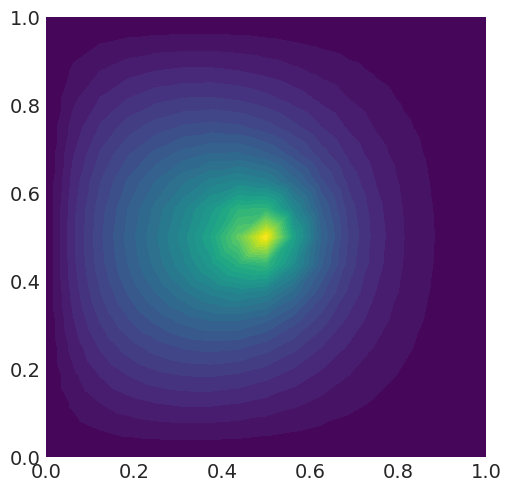

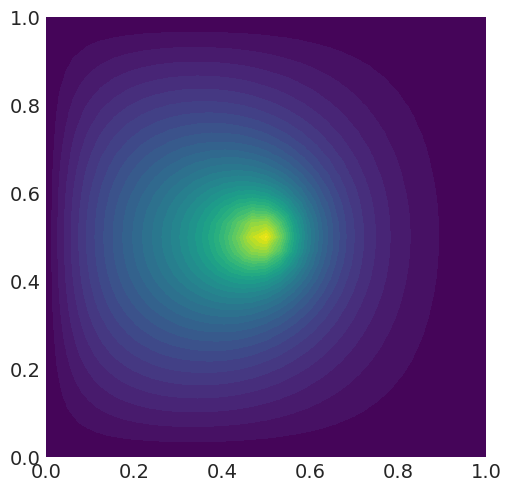

[0.010668039321899414, 0.03221893310546875]


In [11]:
# Initialize the models, according to the mesh refinement degrees

my_models = []

for i in range(len(n_data_hv_levels)):
    my_models.append(CometEquation_Forward(x_0, forcing, poly_degree, n_data_hv_levels[i], data_grid, sigma[i]))


# Plot the solutions and compare meshes

my_models_time = []


for current_model in my_models:

    begin = time.time()
    current_model.solve(mu_true, theta_true)
    my_models_time.append(time.time()-begin)

    plt.figure()
    current_model.plot_model()

plt.show()

print(my_models_time)

## Define a Theano Op for the likelihood

See https://docs.pymc.io/en/stable/pymc-examples/examples/case_studies/blackbox_external_likelihood.html for the complete explanation of the procedure

In [12]:
# Define log likelihood

def my_loglik(my_model, mu_random, theta_random, model_true):

    my_model.solve(mu_random, theta_random)                                                           # compute the PDE solution
    return - np.sum((my_model.grid_solution - model_true.grid_data) ** 2) / (2 * (my_model.sigma)**2) # compare the solution with the data

In [13]:
# Define Theano operation class to compute custom log likelihood

class LogLike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, model_true, pymc3_model): # add inputs as class attributes

        self.my_model    = my_model
        self.likelihood  = loglike
        self.model_true  = model_true
        self.pymc3_model = pymc3_model

    
    def perform(self, node, inputs, outputs):          # the method that is used when calling the Op
        
        # Store random parameters
        (params,) = inputs 

        # Save the quantity of interest to the pymc3 model variable Q
        self.pymc3_model.Q.set_value(QoIs(params))

        # Calculate the likelihood value
        outputs[0][0] = np.array(self.likelihood(self.my_model, params[0], params[1], self.model_true))


## Create coarse models in PyMC3

In [14]:
# Set up models in pymc3 for each level - excluding finest model level

logl          = []
coarse_models = []


for j in range(len(my_models) - 1):

    with pm.Model() as model:
        
        # Instantiate the quantity of interest Q

        Q = pm.Data("Q", np.ndarray(shape=(n_qoi,), buffer=np.zeros(n_qoi)))

        prova = pm.Data('prova', 0) # TEST REFERENCE COPY

        # Uniform (independent?) priors

        mu_random    = pm.Uniform(name = 'mu_random',    lower = lower_mu,    upper = upper_mu)
        theta_random = pm.Uniform(name = 'theta_random', lower = lower_theta, upper = upper_theta)

        params = tt.as_tensor_variable([mu_random, theta_random])


        # Loglikelihood

        logl.append(LogLike(my_models[j], my_loglik, model_true, model))

        pm.Potential("likelihood", logl[j](params))


    coarse_models.append(model)

Solving linear variational problem.


In [15]:
coarse_models[0]["prova"].set_value(2)
logl[0].pymc3_model['prova'].get_value()

array(2.)

## Create fine model and perform inference

Note that we may sample using all 2 methods and that we use the MAP as the starting point for sampling

In [16]:
method_names = []
traces       = []
runtimes     = []
colors       = []


# Set up finest model and perform inference with PyMC3, using the MLDA algorithm and passing the coarse_models list created above, and Metropolis.

with pm.Model() as model:

    # Instantiate the quantity of interest Q
    
    Q = pm.Data("Q", np.ndarray(shape=(n_qoi,), buffer=np.zeros(n_qoi)))

    # Uniform (independent?) priors

    mu_random    = pm.Uniform(name = 'mu_random',    lower = lower_mu,    upper = upper_mu)
    theta_random = pm.Uniform(name = 'theta_random', lower = lower_theta, upper = upper_theta)

    params = tt.as_tensor_variable([mu_random, theta_random])

    # Loglikelihood

    logl.append(LogLike(my_models[-1], my_loglik, model_true, model))

    pm.Potential('likelihood', logl[-1](params))


    # Set the starting point for sampling
    
    if use_MAP_as_start:
        starting_point = pm.find_MAP()
    else:
        starting_point = {'mu_random': mu_0, 'theta_random': theta_0}
    
    print('Starting Point:')
    print(starting_point)

    # Perform Metropolis

    if(perform_M):

        step_M = pm.Metropolis(tune          = tune, 
                               tune_interval = tune_interval)


        t_start = time.time()

        trace_M = pm.sample(draws                = ndraws_M,
                            step                 = step_M,
                            chains               = nchains_M,
                            tune                 = nburn_M,
                            discard_tuned_samples= discard_tuning,
                            random_seed          = RANDOM_SEED,
                            start                = starting_point,
                            cores                = 1)

        runtime_M = time.time() - t_start

        method_names.append('Metropolis')
        traces.append(trace_M)
        runtimes.append(runtime_M)
        colors.append('deepskyblue')


    # Perform MLDA without Variance Reduction

    if(perform_MLDA_without_variance_reduction):
        
        # MLDA without variance reduction
        step_MLDA = pm.MLDA(coarse_models      = coarse_models,
                            subsampling_rates  = nsub_MLDA,
                            base_tune_interval = tune_interval,
                            variance_reduction = False,
                            store_Q_fine       = True)
                            #base_S = (1e-1)*np.eye(2)    # non si sa quale sia il default
                            #base_scaling = 0.001         # questo è il default

        t_start = time.time()

        trace_MLDA_without_variance_reduction = pm.sample(draws                = ndraws_MLDA,
                                                          step                 = step_MLDA,
                                                          chains               = nchains_MLDA,
                                                          tune                 = nburn_MLDA,
                                                          discard_tuned_samples= discard_tuning,
                                                          random_seed          = RANDOM_SEED,
                                                          cores                = 1,
                                                          start                = starting_point)

        runtime_MLDA_without_VR = time.time() - t_start

        method_names.append('MLDA without VR')
        traces.append(trace_MLDA_without_variance_reduction)
        runtimes.append(runtime_MLDA_without_VR)
        colors.append('red')

    
    # Perform MLDA with Variance Reduction
    
    if(perform_MLDA_with_variance_reduction): 

        # MLDA with variance reduction
        step_MLDA = pm.MLDA(coarse_models      = coarse_models,
                            subsampling_rates  = nsub_MLDA,
                            base_tune_interval = tune_interval,
                            variance_reduction = True)

        t_start = time.time()

        trace_MLDA_with_variance_reduction = pm.sample(draws                = ndraws_MLDA,
                                                       step                 = step_MLDA,
                                                       chains               = nchains_MLDA,
                                                       tune                 = nburn_MLDA,
                                                       discard_tuned_samples= discard_tuning,
                                                       random_seed          = RANDOM_SEED,
                                                       cores                = 1,
                                                       start                = starting_point)

        runtime_MLDA_with_VR = time.time() - t_start

        method_names.append('MLDA with VR')
        traces.append(trace_MLDA_with_variance_reduction)
        runtimes.append(runtime_MLDA_with_VR)
        colors.append('darkorange')

Solving linear variational problem.
Starting Point:
{'mu_random': 3.5, 'theta_random': 2}


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [theta_random]
>Metropolis: [mu_random]


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Solving linear variational problem.
Solving linear v

Sampling 1 chain for 300 tune and 2_700 draw iterations (300 + 2_700 draws total) took 5488 seconds.
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (2700) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


Solving linear variational problem.


/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/step_methods/mlda.py:386: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
Sequential sampling (1 chains in 1 job)
MLDA: [theta_random, mu_random]


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/step_methods/mlda.py:386: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

# Visualize summary quantities

In [17]:
# Summary quantities

ess          = []  # collect ESS
ess_n        = []  # collect ESS normlized wrt number of samples
acc          = []  # collect acceptance rates
performances = []  # collect ESS per second

with model:

    for i, trace in enumerate(traces):

        print(f"\n{method_names[i]} Sampler:\n")
        print('mu:    ', mu_true)
        print('theta: ', theta_true)
        display(pm.stats.summary(trace))

        ess.append  (np.array(pm.ess(trace).to_array()))
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        acc.append  (trace.get_sampler_stats('accepted').mean())
        performances.append(ess[i] / runtimes[i])

        print(f"\n{method_names[i]} Sampler:\n"
              f'\nAcceptance rate:     {acc[i]}'
              f'\nRuntime:             {runtimes[i]} seconds'
              f'\nESS list:            {ess[i]}'
              f'\nNormalised ESS list: {ess_n[i]}'
              f'\nESS/sec:             {performances[i]}\n\n\n')

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (2700) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 2700), minimum_shape: (chains=2, draws=4)



Metropolis Sampler:

mu:     2
theta:  3.141592653589793


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_random,2.604,0.848,1.223,4.235,0.054,0.040,291.0,267.0,NaN
theta_random,3.091,0.782,1.744,4.837,0.038,0.027,415.0,433.0,NaN


/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (2700) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1300), minimum_shape: (chains=2, draws=4)



Metropolis Sampler:

Acceptance rate:     0.4764814814814815
Runtime:             5487.853371143341 seconds
ESS list:            [290.88755552 414.55269861]
Normalised ESS list: [0.10773613 0.15353804]
ESS/sec:             [0.05300571 0.07554005]




MLDA without VR Sampler:

mu:     2
theta:  3.141592653589793


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_random,2.732,0.906,1.299,4.534,0.102,0.074,93.0,124.0,NaN
theta_random,3.121,0.776,1.731,4.626,0.074,0.059,115.0,26.0,NaN



MLDA without VR Sampler:

Acceptance rate:     0.29615384615384616
Runtime:             5609.425878047943 seconds
ESS list:            [ 93.27926223 114.92164731]
Normalised ESS list: [0.07175328 0.08840127]
ESS/sec:             [0.01662902 0.02048724]




MLDA with VR Sampler:

mu:     2
theta:  3.141592653589793


arviz - WARNING - Shape validation failed: input_shape: (1, 1300), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_random,2.679,0.847,1.420,4.463,0.077,0.054,128.0,169.0,NaN
theta_random,3.152,0.789,1.861,4.799,0.068,0.049,124.0,156.0,NaN



MLDA with VR Sampler:

Acceptance rate:     0.24615384615384617
Runtime:             5976.998172044754 seconds
ESS list:            [127.93449698 123.65118864]
Normalised ESS list: [0.09841115 0.0951163 ]
ESS/sec:             [0.02140447 0.02068784]





## Plot ESS and ESS per second quantities

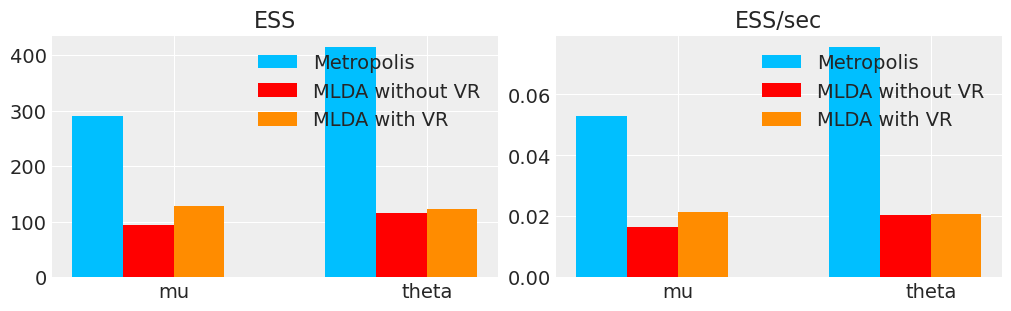

In [18]:
# Plot the effective sample size (ESS) and relative ESS (ES/sec) of each of the sampling strategies

with model:

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].set_title("ESS")
    for i, e in enumerate(ess):
        axes[0].bar(
                    [j + i * 0.2 for j in range(n_params)],
                    e.ravel(),
                    width=0.2,
                    color=colors[i],
                    label=method_names[i],
                    )
    axes[0].set_xticks([i + 0.3 for i in range(n_params)])
    axes[0].set_xticklabels(["mu", "theta"])
    axes[0].legend()

    axes[1].set_title("ESS/sec")
    for i, p in enumerate(performances):
        axes[1].bar(
                    [j + i * 0.2 for j in range(n_params)],
                    p.ravel(),
                    width=0.2,
                    color=colors[i],
                    label=method_names[i],
                    )
    axes[1].set_xticks([i + 0.3 for i in range(n_params)])
    axes[1].set_xticklabels(["mu", "theta"])
    axes[1].legend()
    plt.show()

## Plot traces and posteriors

Metropolis


/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (2700) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


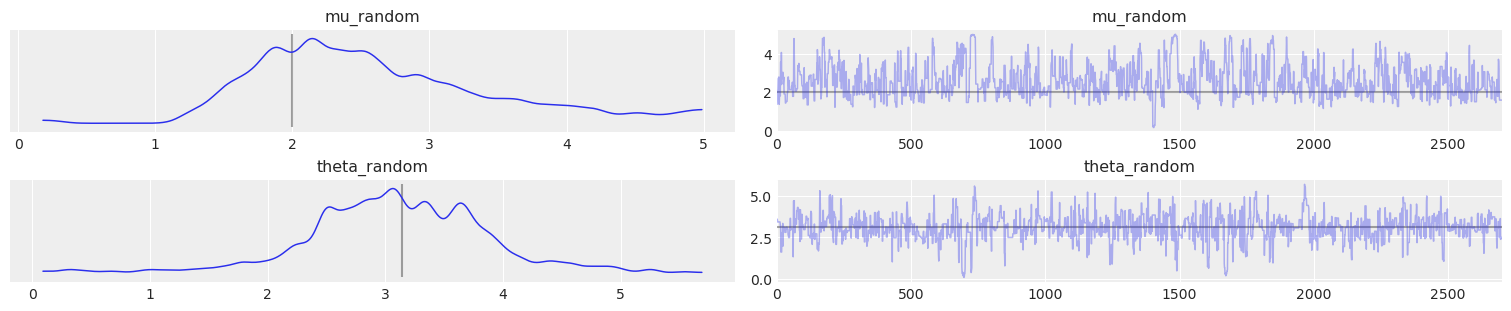





MLDA without VR


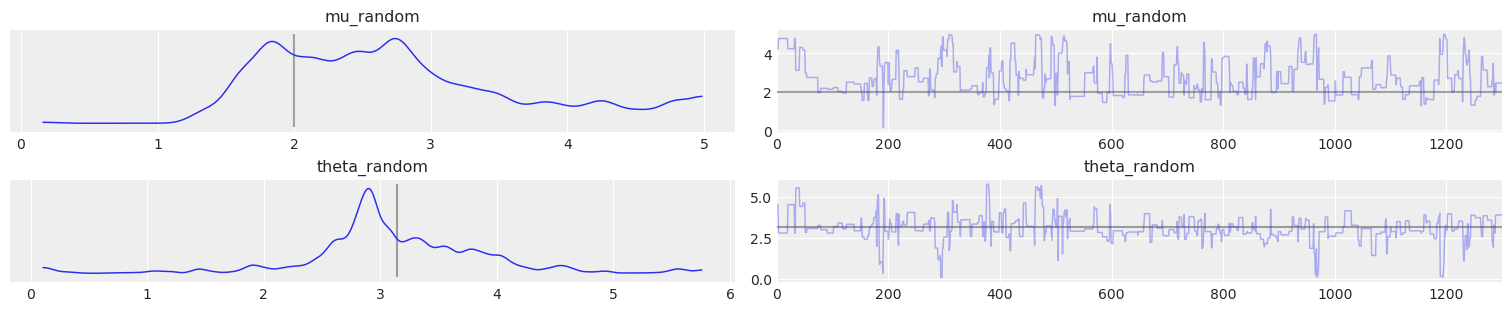





MLDA with VR


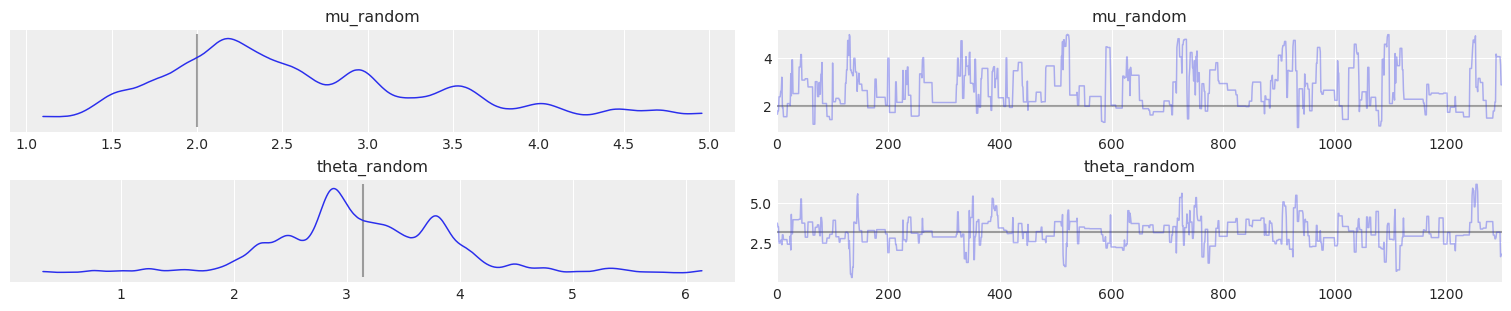

In [19]:
# Plot traces and posteriors

with model:
    
    lines = [('mu_random', {}, mu_true), ('theta_random', {}, theta_true)]

    for i, trace in enumerate(traces):
        print(method_names[i])
        ax2 = az.plot_trace(trace, lines=lines, figsize=(15,3))
        fig2 = ax2.ravel()[0].figure
        fig2.savefig("output.png")
        plt.show()
        print('\n\n\n')
    
    

## Plot autocorrelation

Got error No model on context stack. trying to find log_likelihood in translation.


Metropolis


/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (2700) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


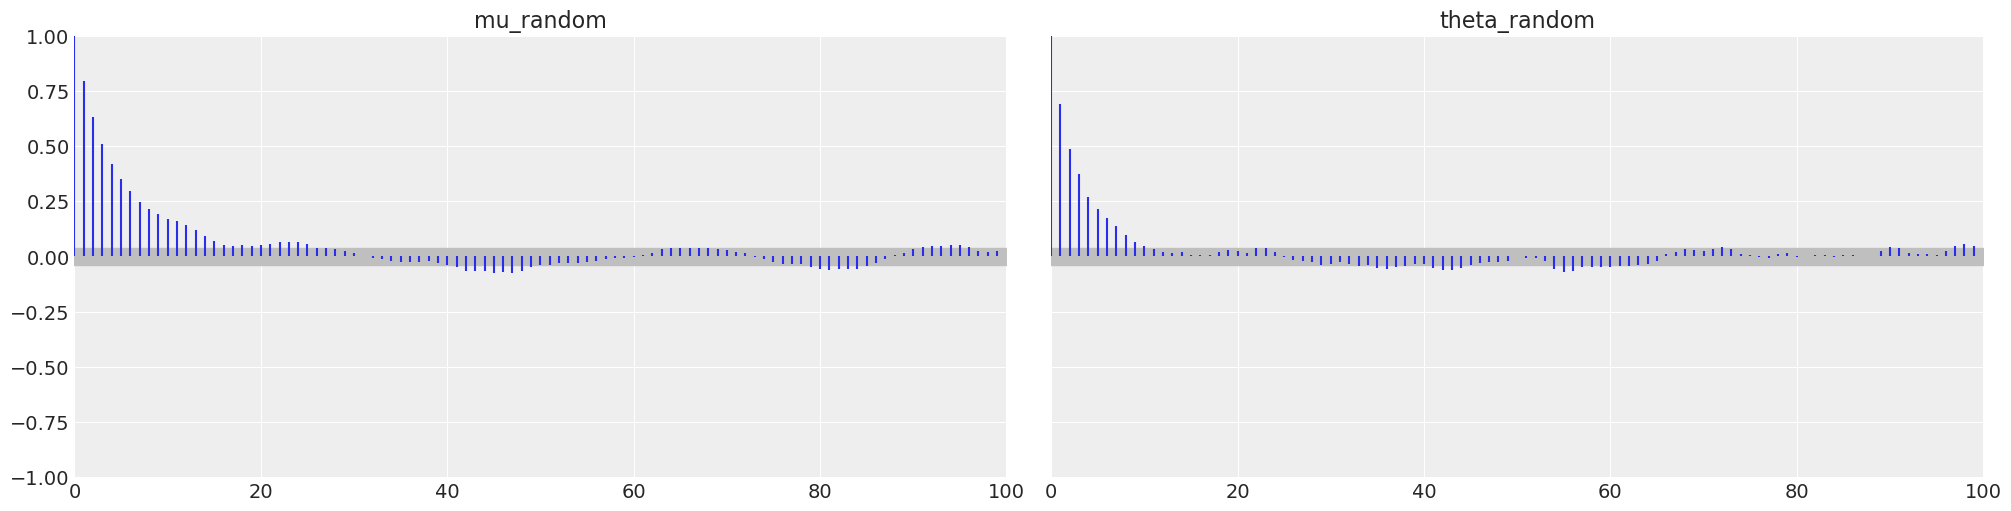

Got error No model on context stack. trying to find log_likelihood in translation.






MLDA without VR


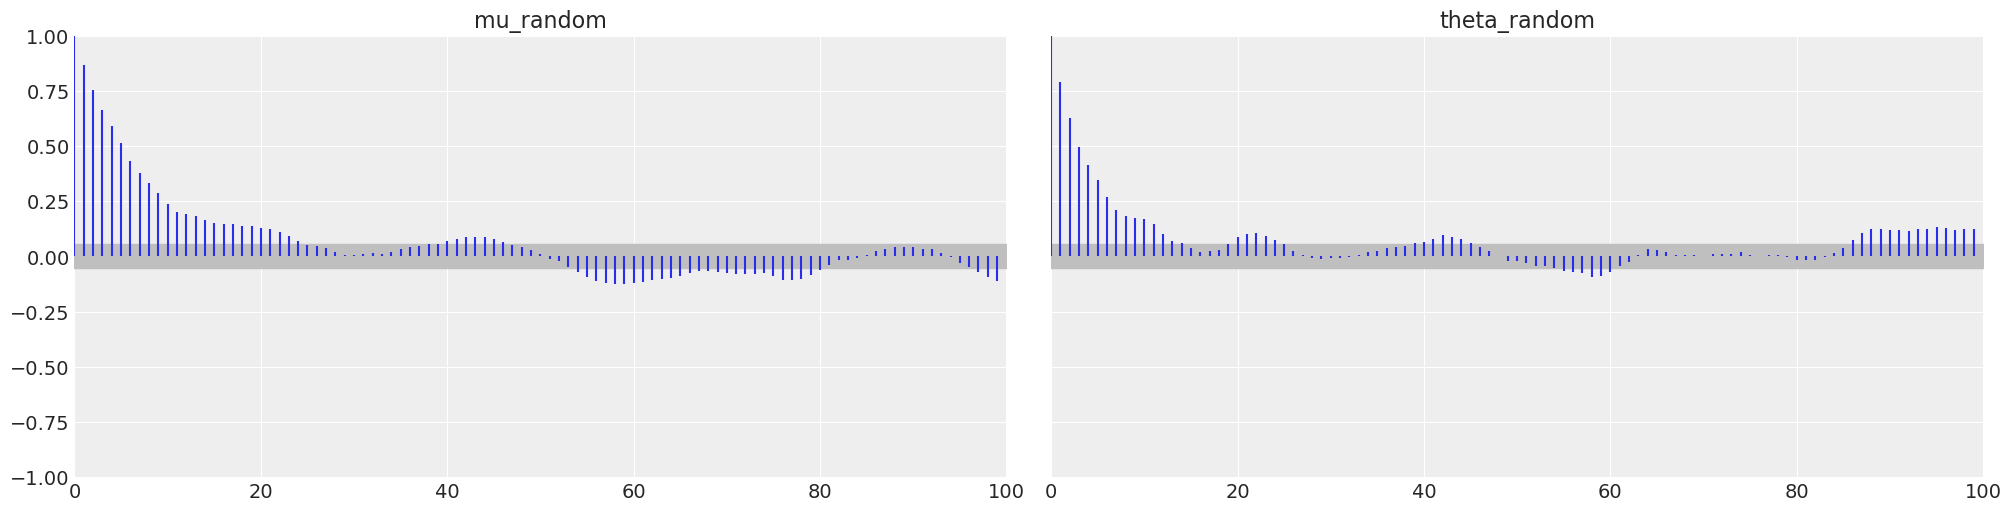

Got error No model on context stack. trying to find log_likelihood in translation.






MLDA with VR


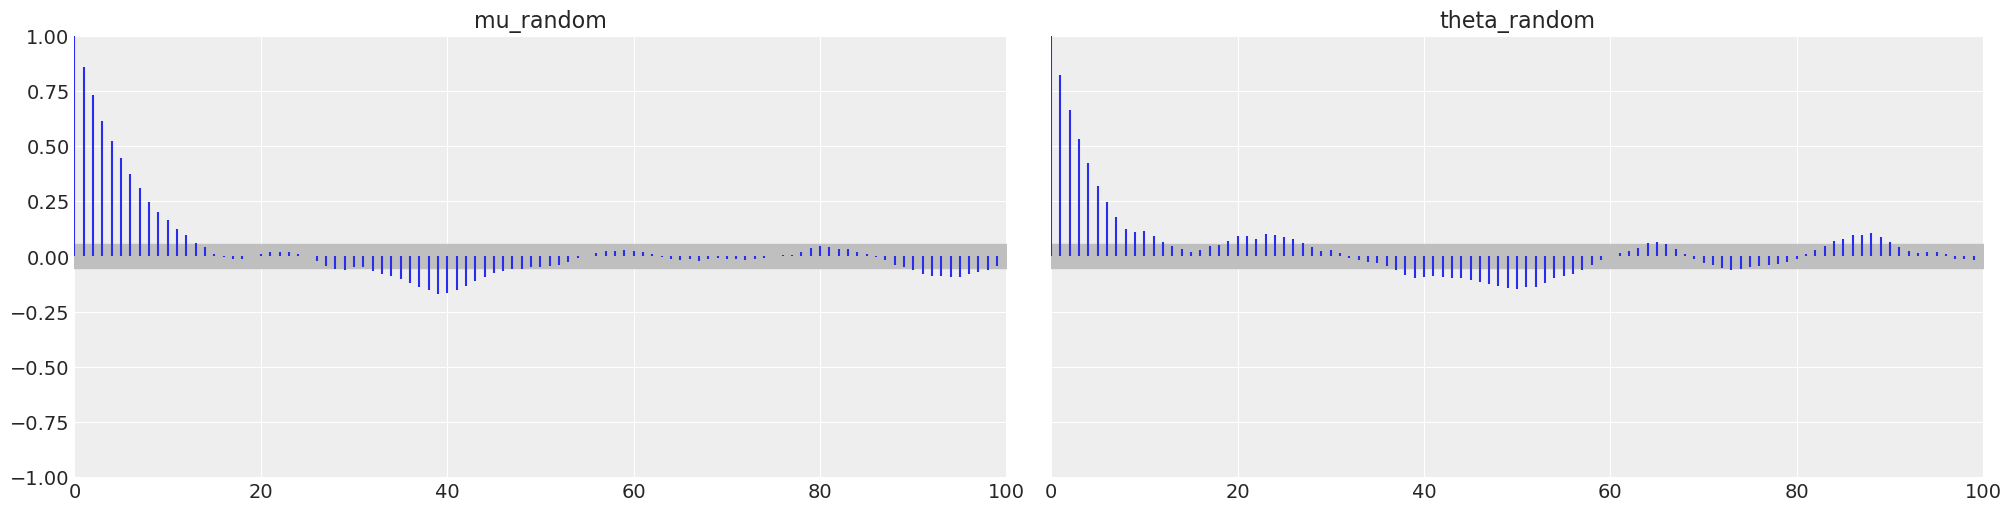

In [20]:
# Plot autocorrelation

for i, trace in enumerate(traces):
    print(method_names[i])
    ax3 = az.plot_autocorr(trace, figsize=(20,5), combined=True)
    fig3 = ax3.ravel()[0].figure
    fig3.savefig("autocorr.png")
    plt.show()
    print('\n\n\n')

# Plot likelihood

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

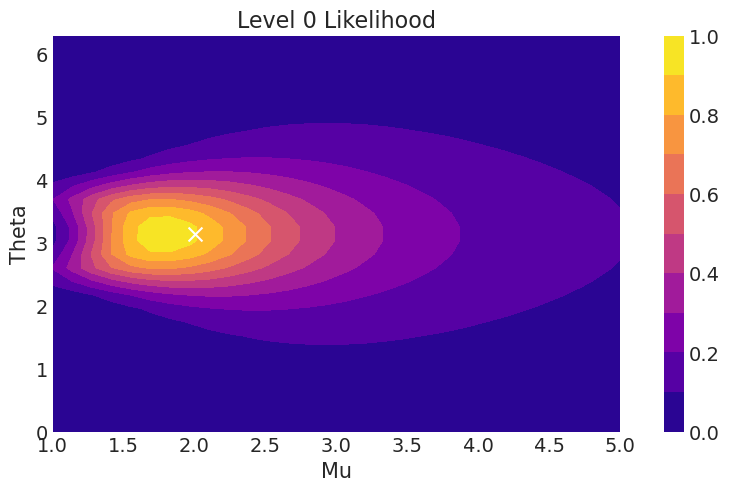

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

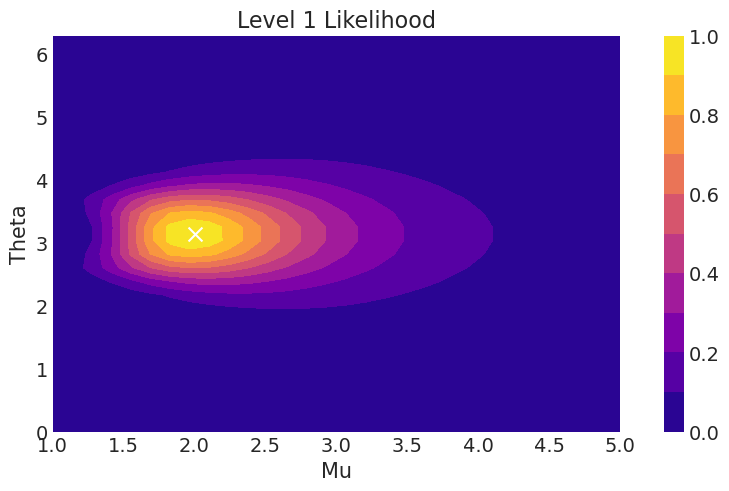

In [21]:
# Likelihood as a function of the random parameters

if (plot_likelihood):

    mu_range    = np.linspace(1,   5,       n_ref_lik)
    theta_range = np.linspace(0,   2*np.pi, n_ref_lik)

    mu_test, theta_test = np.meshgrid(mu_range,theta_range)

    for l in range(len(n_data_hv_levels)):

        loglik_test = np.ones(shape = mu_test.shape)

        for i in range(len(mu_test)):
            for j in range(len(mu_test)):
                
                loglik_test[i][j] = my_loglik(my_models[l], mu_test[i][j], theta_test[i][j], model_true)

        #contours = plt.contour(mu_test, theta_test, np.exp(loglik_test), contour_lik, colors='black')
        #plt.clabel(contours, inline=True, fontsize=8, fmt="%1.6f")

        sf = plt.contourf(mu_test, theta_test, np.exp(loglik_test), contour_lik, cmap='plasma')   #RdGy
        plt.scatter(mu_true,theta_true, marker='x', s = 100, c='white')
        plt.colorbar(sf)
        plt.title('Level ' + str(l) + ' Likelihood')
        plt.xlabel("Mu")
        plt.ylabel("Theta")
        plt.savefig("likel" + str(l) + ".png")
        plt.show()
        

# Estimates Standard Errors of the methods



In [22]:
## Extract quantities of interest from the traces

# MLDA without VR
if(perform_MLDA_without_variance_reduction):
  Q_1 = trace_MLDA_without_variance_reduction.get_sampler_stats("Q_1").reshape((nchains_MLDA * ndraws_MLDA,)) # Q_i where i=levels-1
  Q_1 = np.array(list(Q_1))

# MLDA with VR
if(perform_MLDA_with_variance_reduction):

  # PAY ATTENTION ON HOW MANY TIMES YOU HAVE TO MULTIPLY BY NSUB: IT DEPENDS ON THE LEVELS
  Q_0   = np.concatenate(trace_MLDA_with_variance_reduction.get_sampler_stats("Q_0")).reshape((nchains_MLDA * ndraws_MLDA * nsub_MLDA, n_qoi)) 
  Q_1_0 = np.concatenate(trace_MLDA_with_variance_reduction.get_sampler_stats("Q_1_0")).reshape((nchains_MLDA * ndraws_MLDA, n_qoi))

# Estimates

if(perform_MLDA_without_variance_reduction):
  Q_mean_standard = Q_1.mean(axis = 0)
  print(f"Q_1 mean   = {Q_1.mean(axis = 0)}\n")


if(perform_MLDA_with_variance_reduction):
  Q_mean_vr = Q_0.mean(axis=0) + Q_1_0.mean(axis=0)
  print(f"Q_0 mean   = {Q_0.mean(axis=0)}")
  print(f"Q_1_0 mean = {Q_1_0.mean(axis=0)}\n")


if(perform_MLDA_without_variance_reduction):
  print(f"Standard method:    Mean: {Q_mean_standard}\n")


if(perform_MLDA_with_variance_reduction):
  print(f"VR method:          Mean: {Q_mean_vr}\n")

Q_1 mean   = [2.73155978 3.12058702]

Q_0 mean   = [2.65406872 3.09463676]
Q_1_0 mean = [0. 0.]

Standard method:    Mean: [2.73155978 3.12058702]

VR method:          Mean: [2.65406872 3.09463676]



In [23]:
# Calculate variances of Q quantity samples

if(perform_MLDA_without_variance_reduction):
  Q_1_var = Q_1.var(axis=0)
  print(f"Q_1 var   = {Q_1_var}\n")


if(perform_MLDA_with_variance_reduction):
  Q_0_var   = Q_0.var(axis=0)
  Q_1_0_var = Q_1_0.var(axis=0)
  print(f"Q_0 var   = {Q_0_var}")
  print(f"Q_1_0_var = {Q_1_0_var}\n")

Q_1 var   = [0.82098505 0.6011739 ]

Q_0 var   = [0.88658918 0.8499351 ]
Q_1_0_var = [0. 0.]



In [24]:
## Calculate standard error of each term using ESS

if(perform_MLDA_without_variance_reduction):

  ess_Q1 = np.zeros(n_qoi)
  for i in range(n_qoi):
    ess_Q1[i] = az.ess(np.array(Q_1[:,i], np.float64))

  print("Without VR ESS:  ", ess_Q1)

  # Standard Error Estimate
  print("Without VR Standard Error: ", Q_1_var/ess_Q1)

if(perform_MLDA_with_variance_reduction):

  # note that the chain in level 1 has much fewer samples than the chain in level 0 (because of the subsampling rates)
  ess_Q0 = np.zeros(n_qoi)
  ess_Q_1_0 = np.zeros(n_qoi)
  for i in range(n_qoi):
    ess_Q0[i]    = az.ess(np.array(Q_0[:,i],   np.float64))
    ess_Q_1_0[i] = az.ess(np.array(Q_1_0[:,i], np.float64))

  print("With VR ESSes:   ", ess_Q0, ess_Q_1_0)

  # Standard Error Estimates
  print("With VR Standard Errors:   ", Q_0_var/ess_Q0,'   ', Q_1_0_var/ess_Q_1_0)

Without VR ESS:   [ 93.27926223 114.92164731]
Without VR Standard Error:  [0.00880137 0.00523116]
With VR ESSes:    [148.0274319  215.98095789] [1300. 1300.]
With VR Standard Errors:    [0.00598936 0.00393523]     [0. 0.]


arviz - WARNING - Shape validation failed: input_shape: (1, 2), minimum_shape: (chains=1, draws=4)


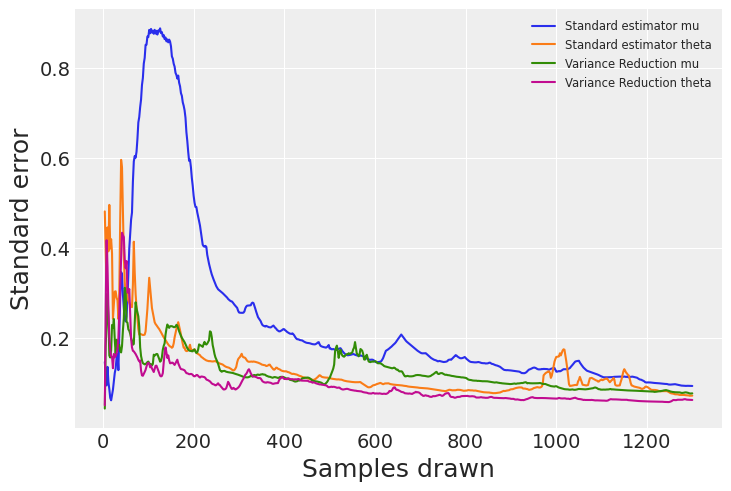

In [25]:
## Calculate total standard errors of the two competing estimates with different chunks of the sample

step = 2  # 100

if(perform_MLDA_without_variance_reduction):
  Q1_SE         = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))
  E_standard_SE = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))


if(perform_MLDA_with_variance_reduction):
  Q0_SE    = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))
  Q_1_0_SE = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))
  E_VR_SE  = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))

k = 0

for i in np.arange(step, nchains_MLDA * ndraws_MLDA + 1, step):

  for q in range(n_qoi):      

    try:
      Q1_SE[k,q] = Q_1[0:i, q].var(axis=0) / az.ess(np.array(Q_1[0:i,q], np.float64))
      E_standard_SE[k,q] = np.sqrt(Q1_SE[k,q])
    except:
      pass

    try:
      Q0_SE   [k,q] = Q_0  [0 : i * nsub_MLDA, q].var(axis=0) / az.ess(np.array(Q_0[0 : i * nsub_MLDA,q], np.float64))
      Q_1_0_SE[k,q] = Q_1_0[0 : i,             q].var(axis=0) / az.ess(np.array(Q_1_0[0 : i,             q], np.float64))
      E_VR_SE [k,q] = np.sqrt(Q0_SE[k,q] + Q_1_0_SE[k,q])
    except:
      pass

  k += 1

fig = plt.figure()
ax  = fig.gca()
legend_strings = []

for axis in [ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

if(perform_MLDA_without_variance_reduction):
  ax.plot(np.arange(step, nchains_MLDA * ndraws_MLDA + 1, step), E_standard_SE)
  legend_strings.append(f"Standard estimator {qoi_names[0]}")
  legend_strings.append(f"Standard estimator {qoi_names[1]}")


if(perform_MLDA_with_variance_reduction):
  ax.plot(np.arange(step, nchains_MLDA * ndraws_MLDA + 1, step), E_VR_SE)
  legend_strings.append(f"Variance Reduction {qoi_names[0]}")
  legend_strings.append(f"Variance Reduction {qoi_names[1]}")

ax.legend(legend_strings, fontsize = "small")

plt.xlabel("Samples drawn",  fontsize=18)
plt.ylabel("Standard error", fontsize=18)

plt.savefig('mu_sigma_std_err.png')
plt.show()